
### Models: Sentence Sentiment Classification
Our goal is to create a model that takes a sentence (just like the ones in our dataset) and produces either 1 (indicating the sentence carries a positive sentiment) or a 0 (indicating the sentence carries a negative sentiment). We can think of it as looking like this:

<img src="https://jalammar.github.io/images/distilBERT/sentiment-classifier-1.png" />

Under the hood, the model is actually made up of two model.

* DistilBERT processes the sentence and passes along some information it extracted from it on to the next model. DistilBERT is a smaller version of BERT developed and open sourced by the team at HuggingFace. It’s a lighter and faster version of BERT that roughly matches its performance.
* The next model, a basic Logistic Regression model from scikit learn will take in the result of DistilBERT’s processing, and classify the sentence as either positive or negative (1 or 0, respectively).

The data we pass between the two models is a vector of size 768. We can think of this of vector as an embedding for the sentence that we can use for classification.


<img src="https://jalammar.github.io/images/distilBERT/distilbert-bert-sentiment-classifier.png" />

## Dataset
The dataset we will use in this example is [SST2](https://nlp.stanford.edu/sentiment/index.html), which contains sentences from movie reviews, each labeled as either positive (has the value 1) or negative (has the value 0):


<table class="features-table">
  <tr>
    <th class="mdc-text-light-green-600">
    sentence
    </th>
    <th class="mdc-text-purple-600">
    label
    </th>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      apparently reassembled from the cutting room floor of any given daytime soap
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      they presume their audience won't sit still for a sociology lesson
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      this is a visually stunning rumination on love , memory , history and the war between art and commerce
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      jonathan parker 's bartleby should have been the be all end all of the modern office anomie films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
</table>

## Installing the transformers library
Let's start by installing the huggingface transformers library so we can load our deep learning NLP model.

In [ ]:
!pip install transformers

[Transformers library doc](https://huggingface.co/transformers/)

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

### Importing the dataset

In [4]:
df = pd.read_csv(
    'https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv',
    delimiter='\t',
    header=None
)
print(df.shape)
df.head()

### Using BERT for text classification.

Let's now load a pre-trained BERT model. 

In [ ]:
# For DistilBERT, Load pretrained model/tokenizer:

model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
# look at the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

In [ ]:
from termcolor import colored

colors = ['red', 'green', 'blue', 'yellow']

def model_structure(layer, margin=0, item_color=0):
    for name, next_layer in layer.named_children():

        next = (0 if not list(next_layer.named_children()) else 1)
        print(colored(' ' * margin + name, colors[item_color]) + ':' * next)
        model_structure(next_layer, margin + len(name) + 2, (item_color + 1) % 4)

model_structure(model)

### Preparing the dataset

In [8]:
from torch.utils.data import Dataset, random_split

class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=df, tokenizer=tokenizer, max_length=128):
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[1].values)
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """

        text = self.dataset[0][idx]
        label = self.dataset[1][idx]
        
        tokenizer_output = tokenizer.encode_plus(
        text, 
        max_length=self.max_length, # максимальная длина текста
        padding="max_length", # надо ли добавлять паддинг в конце?
        return_tensors="pt", # возвращает pytorch тензоры
        )
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output['input_ids'].view(-1), 
            "mask": tokenizer_output['attention_mask'].view(-1),
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset)

dataset = ReviewsDataset(df)

# DON'T CHANGE, PLEASE
train_size, val_size = int(.8 * len(dataset)), int(.1 * len(dataset))
torch.manual_seed(2) 
train_data, valid_data, test_data = random_split(dataset, [train_size, val_size, len(dataset) - train_size - val_size])

print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

In [9]:
from torch.utils.data import DataLoader

batch_size=32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

### Baseline

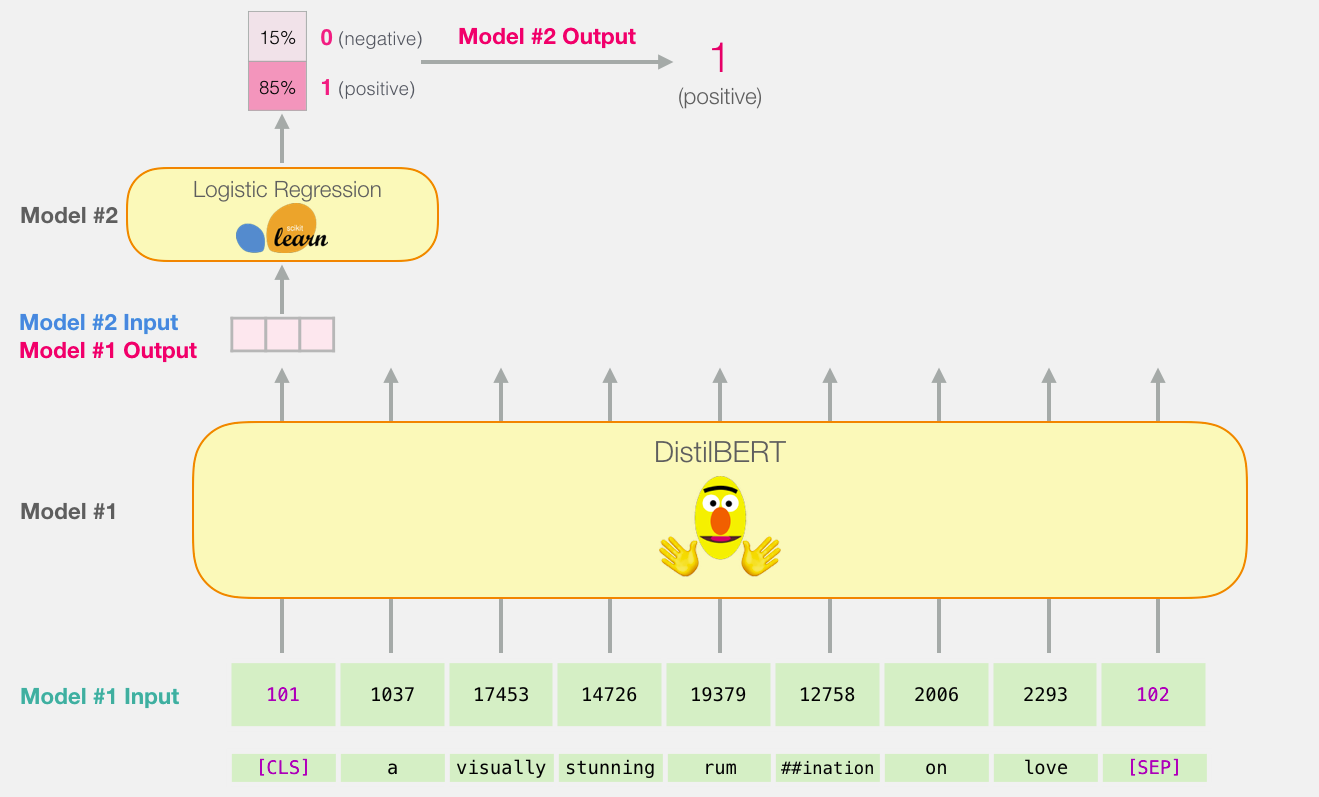

In [56]:
from tqdm.notebook import tqdm

def get_xy(loader):
    features = []
    labels = []
    i = 0
    with torch.no_grad():
        for batch in tqdm(loader):
            # don't forget about .to(device)
            output = model(input_ids=batch['input_ids'].to(device), attention_mask=batch['mask'].to(device), output_hidden_states=True)
            hidden_states, last = output.hidden_states, output.last_hidden_state
            labels.append(batch['target'].cpu())
            features.append(torch.cat([hidden_states[3][:, 0, :], hidden_states[4][:, 0, :], hidden_states[5][:, 0, :], hidden_states[6][:, 0, :]], dim=1).cpu())
            
    features = torch.cat(features, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

    return features, labels

In [57]:
train_features, train_labels = get_xy(train_loader)
valid_features, valid_labels = get_xy(valid_loader)
test_features, test_labels = get_xy(test_loader)

In [59]:
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)

### Fine-Tuning BERT

Define the model

In [25]:
from torch import nn

class BertClassifier(nn.Module):
    def __init__(self, pretrained_model, dropout=0.1):
        super().__init__()

        self.bert = pretrained_model

        self.dropout = nn.Dropout(p=dropout)

        self.classifier = nn.Sequential(
            nn.Linear(768 * 4, 768 * 4),
            nn.BatchNorm1d(768 * 4),
            nn.ReLU(),
            nn.Linear(768 * 4, 1),
            nn.Sigmoid()
        )
    
    def forward(self, inputs, attention_mask):
        
        output = self.bert(input_ids=inputs, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = output.hidden_states
        cat = torch.cat([hidden_states[3][:, 0, :], hidden_states[4][:, 0, :], hidden_states[5][:, 0, :], hidden_states[6][:, 0, :]], dim=1)
        cat = self.dropout(cat)

        # proba = [batch_size, ] - probability to be positive
        proba = self.classifier(cat).view(-1)
        return proba

In [44]:
import torch.optim as optim

# DON'T CHANGE
model = model_class.from_pretrained(pretrained_weights).to(device)

#for param in model.parameters():
#    param.requires_grad = False

bert_clf = BertClassifier(model).to(device)
# you can change
lr = 2e-5
num_batches = 173
N_EPOCHS = 2

optimizer = optim.AdamW(bert_clf.parameters(), lr=lr)
criterion = nn.BCELoss()
scheduler = ppb.optimization.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=num_batches * 2, num_training_steps=N_EPOCHS*num_batches)

In [45]:
from sklearn.metrics import accuracy_score
def train(model, iterator, optimizer, criterion, scheduler, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(tqdm(iterator)):
        
        optimizer.zero_grad()

        output = model(batch['input_ids'].to(device), batch['mask'].to(device))

        loss = criterion(output, batch['target'].to(torch.float32).to(device)) 
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        scheduler.step()
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())

        if (i+1) % 10 == 0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / (i + 1)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
        for i, batch in enumerate(tqdm(iterator)):
            output = model(batch['input_ids'].to(device), batch['mask'].to(device))
            loss = criterion(output, batch['target'].to(torch.float32).to(device))
            epoch_loss += loss.item()
        
    return epoch_loss / (i + 1)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [46]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [47]:
train_history = []
valid_history = []

CLIP = 1

best_valid_loss = float('inf')

for epoch in tqdm(range(N_EPOCHS)):
    
    start_time = time.time()
    
    train_loss = train(bert_clf, train_loader, optimizer, criterion, scheduler, CLIP, train_history, valid_history)
    valid_loss = evaluate(bert_clf, valid_loader, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(bert_clf.state_dict(), 'best-val-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [48]:
best_model = BertClassifier(model).to(device)
best_model.load_state_dict(torch.load('best-val-model.pt'))

pred_labels = []
true_labels = []

best_model.eval()
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):
        output = best_model(batch['input_ids'].to(device), batch['mask'].to(device))
        labels = batch['target'].to(torch.float32).to(device)
        loss = criterion(output, labels)

        pred_labels.append(output.detach().cpu().numpy())
        true_labels.append(labels.cpu().numpy())

In [49]:
from sklearn.metrics import accuracy_score

true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)

In [52]:
accuracy_score(true_labels, pred_labels > 0.5)

In [53]:
assert accuracy_score(true_labels, pred_labels > 0.5) >= 0.86

### Finetuned model from **HUGGING FACE**

[BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html?highlight=bertfor#transformers.BertForSequenceClassification)

In [54]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# we have the same tokenizer
# new_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
new_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english").to(device)

In [ ]:
model_structure(new_model)

In [55]:
pred_labels = []
true_labels = []

new_model.eval()
with torch.no_grad():
    for i, batch in enumerate(tqdm(test_loader)):

        output = new_model(batch['input_ids'].to(device), batch['mask'].to(device))

        labels = batch['target'].to(torch.float32).to(device)
        loss = criterion(output.logits.argmax(-1).to(torch.float32), labels)

        pred_labels.append(output.logits.argmax(-1).detach().cpu().numpy())
        true_labels.append(labels.cpu().numpy())

true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)

accuracy_score(true_labels, pred_labels)

## Напишите вывод о своих результатах. В выводы включите ваши гиперпараметры. 

*Качество с помощью Fine-Tuning должно достигать 0.86.*



Используемые гиперпараметры:

- lr = 2e-5
- num_batches = 173
- N_EPOCHS = 2


- optimizer = optim.AdamW(bert_clf.parameters(), lr=lr)
- criterion = nn.BCELoss()
- scheduler = ppb.optimization.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=num_batches * 2, num_training_steps=N_EPOCHS*num_batches)

Лучше себя показала модель специально обученная для такой классификации, моя модель была чуть хуже, но лучше, чем линейная регрессия.
Так же я попробовал использовать конкатенацию 4 последних слоёв как рекомендовали это сделать в лекции. Scheduler немного улучшил качество, но изменение learning rate чаще вредели, чем помогало, поэтому решил оставить как есть. Пробовал замораживать веса для предобученной модели, чтобы ускорить обучение. Но таким способом максимальный скор становился - 0.82